In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm, tpm_series
from grn_tpm import iit_tpm_cal

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

def serie_plot(bnet, w, k, steps, seeds=1, name='', leg=False):
    tpm, tpm_v = make_tpm(bnet, w=w, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
    colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
    strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
    for init_state in strs:
        fig, ax = plt.subplots(figsize=(5,2))
        for indx,en in enumerate(["00", "01", "10", "11"]):
            en_state = en
            for seed in range(seeds):
                serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

                # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
                ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

        # 设置轴标签
        ax.set_xlabel('Time')
        ax.set_ylabel('System state')

        # 设置y轴的标签
        ax.set_yticks(range(8))
        ax.set_yticklabels(strs)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if leg:
            plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
        plt.title(name + '_init=' + init_state + '_syn=' + str(round(syn,4)))
        # 显示图形
        plt.show()
        
    return un_sys, un_en, syn

bnet = {
    ('B', "C", 'A'): 'bc_a',

    ('E1', 'E2', 'A'): '12_a'

}

In [7]:
k = 1
w = 0.1

def tpm_syn(k, w):
    w_1a_b = w
    w_2a_b = w
    w_1b_c = w
    w_2b_c = w
    w_1c_a = w
    w_2c_a = w
    w_a_b = 1 - w
    w_b_c = 1 - w
    w_c_a = 1 - w
    w_a_a = 1 - w
    w_b_b = 1 - w
    w_c_c = 1 - w
    tpm_list = []
    for j in ['a', 'b', 'c', '1', '2']:
        tpm = np.zeros([32,2])
        for i in range(32):
            inputs = decimal_to_binary(i, min_length=5)
            in_ls = [2*int(n)-1 for n in inputs]
            if j=='a':
                term = w_1c_a*in_ls[2]*in_ls[3] + w_2c_a*in_ls[2]*in_ls[4] + w_c_a*in_ls[2] + w_a_a*in_ls[0]
            elif j=='b':
                term = w_1a_b*in_ls[0]*in_ls[3] + w_2a_b*in_ls[0]*in_ls[4] + w_a_b*in_ls[0] + w_b_b*in_ls[1]
            elif j=='c':
                term = w_1b_c*in_ls[1]*in_ls[3] + w_2b_c*in_ls[1]*in_ls[4] + w_b_c*in_ls[1] + w_c_c*in_ls[2]
            else:
                term = 0.5

            tpm[i,1] = 1. / (1. + np.exp(-k * term))
            tpm[i,0] = 1 - tpm[i,1]
        tpm_list.append(tpm)

    tpm_all = np.ones([32, 32])
    for i in range(32):
        ind_str = decimal_to_binary(i, min_length=5)
        for m, n in enumerate(ind_str):
            tpm_all[:, i] *= tpm_list[m][:, int(n)] 

    return tpm_all



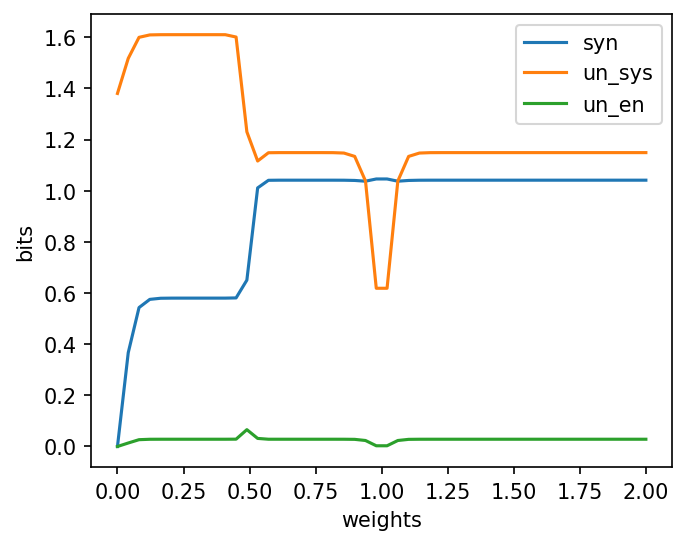

In [11]:
syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 2, 50)
for w in w_axis:
    
    tpm_v = tpm_syn(k=30, w=w)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

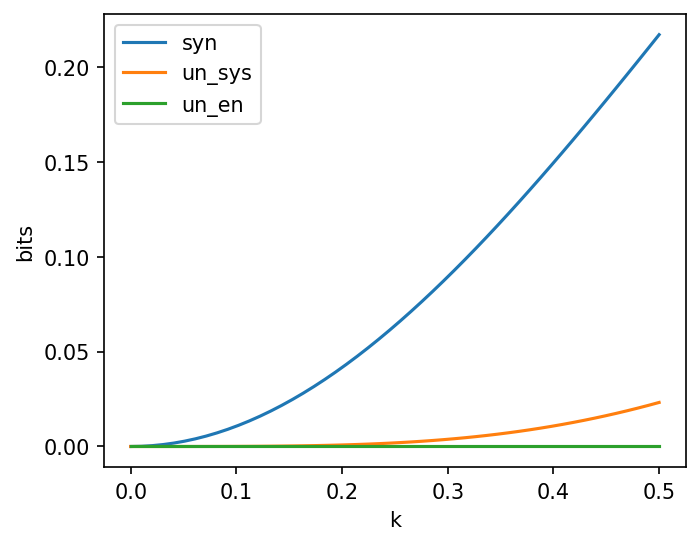

In [17]:
syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0, 0.5, 50)
for k in k_axis:
    
    tpm_v = tpm_syn(k=k, w=1)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
plt.plot(k_axis, un_sys_list, label="un_sys")
plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

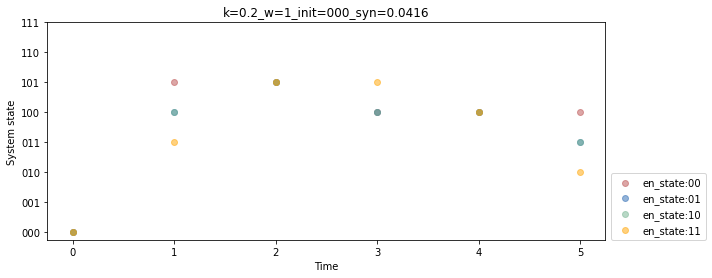

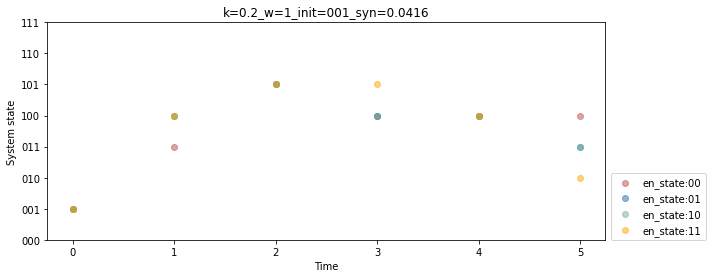

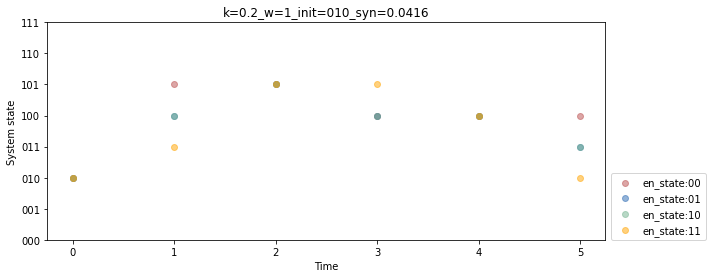

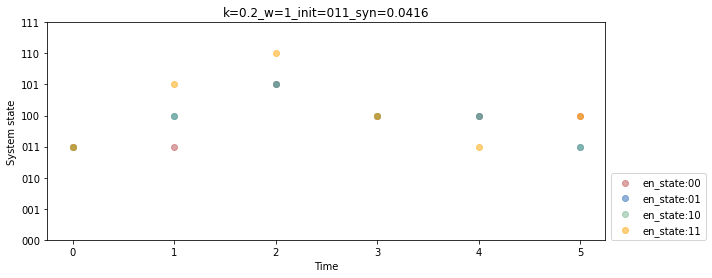

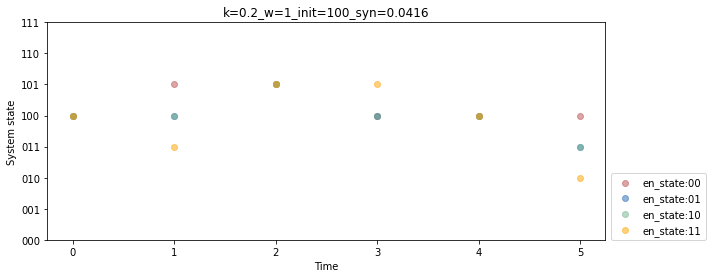

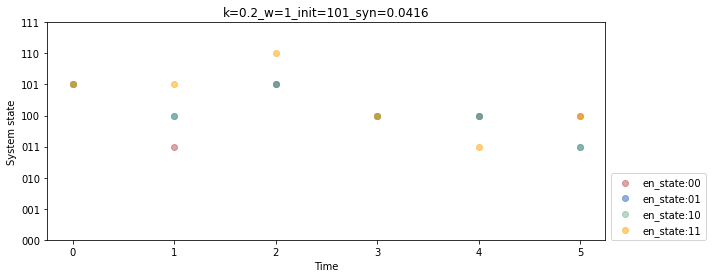

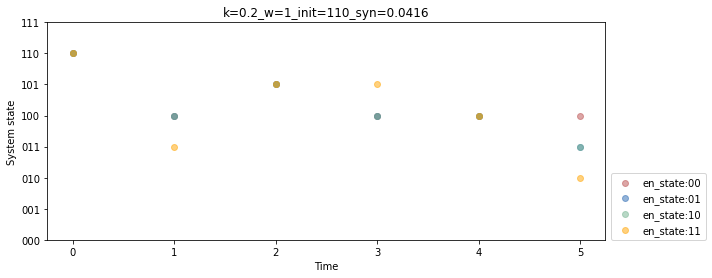

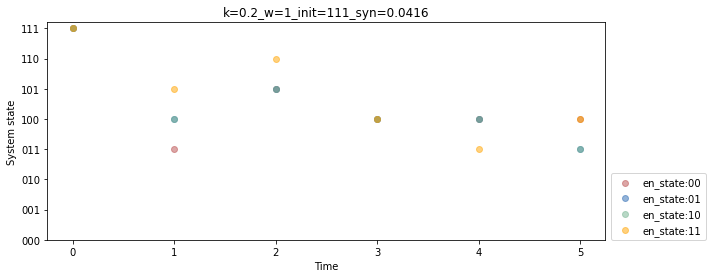

In [21]:
seeds = 1
steps = 5
tpm_v = tpm_syn(k=0.2, w=1)
name = 'k=0.2_w=1'
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
for init_state in strs:
    fig, ax = plt.subplots(figsize=(10,4))
    for indx,en in enumerate(["00", "01", "10", "11"]):
        en_state = en
        for seed in range(seeds):
            serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

            # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
            ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx], alpha=0.5)

    # 设置轴标签
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')

    # 设置y轴的标签
    ax.set_yticks(range(8))
    ax.set_yticklabels(strs)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
    plt.title(name + '_init=' + init_state + '_syn=' + str(round(syn,4)))
    # 显示图形
    plt.show()